In [1]:
import os
import tempfile
cache_dir = tempfile.mkdtemp()
os.environ['XDG_CACHE_HOME'] = cache_dir
import re

from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings

In [2]:
fivemer_mut_path = "../data/mutability/MK_RS5NF_mutability.csv"
fivemer_sub_path = "../data/mutability/MK_RS5NF_substitution.csv"
seq_data_path = "../results/notebooks/10x/data.csv"
final_variant_scores = "data/dms/final_variant_scores.csv"

* Pad the sequence with Ns and get per-site mutabilities and substitutions for each chain
* Concatenate those and the unpadded sequences
* Normalize the mutabilities because we are conditioning on there being a mutation
* For every mutation at every site, get its probability and amino-acid level effect
    * if it WT, we 
Get per-site mutabilities and then transform them into codon things?

In [3]:
fivemer_mut_df = pd.read_csv(fivemer_mut_path, sep=" ", header=0)
fivemer_sub_df = pd.read_csv(fivemer_sub_path, sep=" ", header=0)
fivemer_mut_df.head().to_clipboard()
fivemer_sub_df.head().to_clipboard()


#### Read in the sequences and trim to codon boundary

In [4]:
seq_data_df = pd.read_csv(seq_data_path, usecols=["nt_seq_H", "nt_seq_L", "time (days)"])

# Check for missing values in the sequence columns
assert seq_data_df["nt_seq_H"].isnull().sum() == 0
assert seq_data_df["nt_seq_L"].isnull().sum() == 0

# Trim sequences to codon boundary
seq_data_df["nt_seq_H"] = seq_data_df["nt_seq_H"].apply(lambda x: str(x)[:len(str(x)) // 3 * 3])
seq_data_df["nt_seq_L"] = seq_data_df["nt_seq_L"].apply(lambda x: str(x)[:len(str(x)) // 3 * 3])

# print the length of all the seq columns
print("Length of nt_seq_H:", seq_data_df["nt_seq_H"].str.len().unique())
print("Length of nt_seq_L:", seq_data_df["nt_seq_L"].str.len().unique())

Length of nt_seq_H: [336]
Length of nt_seq_L: [321]


In [5]:
# get the first sequence
seq_data_df["nt_seq_H"].iloc[0], seq_data_df["nt_seq_L"].iloc[0]

('GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTACATCAGCTACAGTGGTAGCACTTACTCCAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCA',
 'GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGCCAGAATGTGGGTACTAATGTAGGCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAA')

In [6]:
final_variant_scores_df = pd.read_csv(final_variant_scores)
final_variant_scores_df = final_variant_scores_df[final_variant_scores_df["chain"] != "link"]
# get the unique "codon" entry for final_variant_scores_df.groupby(["chain", "site"])
unique_codons = final_variant_scores_df.groupby(["chain", "position"])["codon"].unique()
# let unique_codons be the first entry of unique_codons
unique_codons = unique_codons.apply(lambda x: x[0])
# concatenate unique_codons for chain="H" to be one string, naive_H, and for chain="L" to be one string, naive_L
naive_H = "".join(unique_codons.loc["H"])
naive_L = "".join(unique_codons.loc["L"])

len(naive_H), len(naive_L)

(336, 324)

Note above that the naive sequence length is 1 codon longer than the codon-boundary-trimmed 10x data, so we will need to trim the data explicitly.

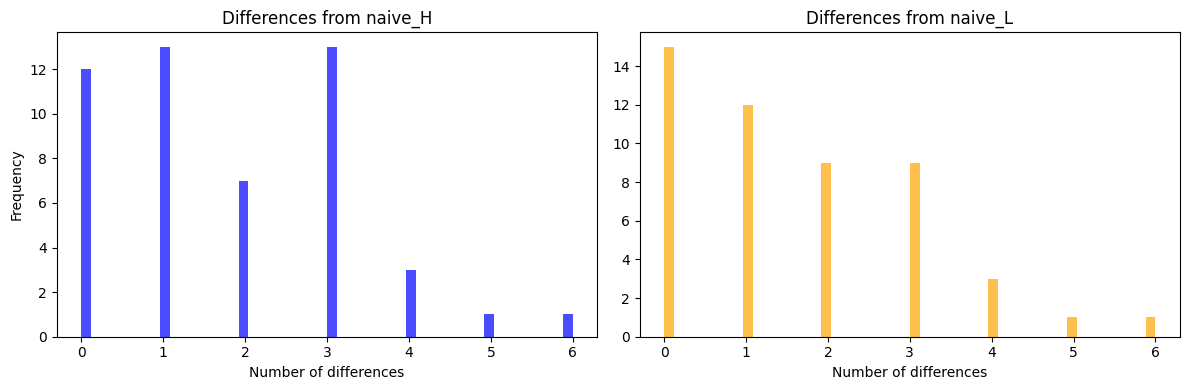

In [13]:
# for nt_seq_H entry, calculate the number of differences from naive_H
def diff(seq1, seq2):
    assert len(seq1) == len(seq2), f"Sequences must be of the same length: {len(seq1)} != {len(seq2)}"
    return sum([1 for a, b in zip(seq1, seq2) if a != b])

seq_data_df["diff_H"] = seq_data_df["nt_seq_H"].apply(lambda x: diff(x, naive_H))
seq_data_df["diff_L"] = seq_data_df["nt_seq_L"].apply(lambda x: diff(x, naive_L[:321]))

# make histograms of diff_H and diff_L
plt.figure(figsize=(12, 4))

# Plot both histograms side by side
plt.subplot(121)
plt.hist(seq_data_df["diff_H"], bins=50, color="blue", alpha=0.7)
plt.title("Differences from naive_H")
plt.xlabel("Number of differences")
plt.ylabel("Frequency")

plt.subplot(122)
plt.hist(seq_data_df["diff_L"], bins=50, color="orange", alpha=0.7)
plt.title("Differences from naive_L")
plt.xlabel("Number of differences")

plt.tight_layout()
plt.show()

# drop the diff_H and diff_L columns
seq_data_df = seq_data_df.drop(columns=["diff_H", "diff_L"])

In [8]:
# Create the mutability dictionary directly from the dataframe
mutability_dict = dict(zip(fivemer_mut_df['Fivemer'], fivemer_mut_df['Mutability']))

def get_sequence_mutability(sequence: str) -> np.ndarray:
    """
    Compute raw mutability scores for each position in a DNA sequence.
    
    Args:
        sequence: A DNA sequence (e.g., "GAGGTGCAGCTT...")
        
    Returns:
        numpy array with raw mutability scores
    """
    sequence = sequence.upper()
    padded_seq = "NN" + sequence + "NN"
    mutability_scores = np.zeros(len(sequence))
    
    for i in range(len(sequence)):
        fivemer = padded_seq[i:i+5]
        mutability_scores[i] = mutability_dict[fivemer]
    
    return mutability_scores


def compute_normalized_mutability_pair(heavy_chain: str, light_chain: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute mutability scores for heavy and light chain sequences, then normalize
    them as if they were a single probability vector.
    
    Args:
        heavy_chain: DNA sequence for heavy chain
        light_chain: DNA sequence for light chain
        
    Returns:
        Tuple of two numpy arrays with normalized mutability scores
    """
    heavy_mutability = get_sequence_mutability(heavy_chain)
    light_mutability = get_sequence_mutability(light_chain)
    
    total_mutability = np.sum(heavy_mutability) + np.sum(light_mutability)
    
    # Normalize both sequences using the same total
    heavy_normalized = heavy_mutability / total_mutability
    light_normalized = light_mutability / total_mutability
    
    return heavy_normalized, light_normalized

In [9]:
# Temporarily take the head of the dataframe for testing
seq_data_df = seq_data_df.head(50)

In [10]:
# Apply the function to each pair of sequences in the dataframe
normalized_mutability_results = []

for _, row in seq_data_df.iterrows():
    heavy_chain = row['nt_seq_H']
    light_chain = row['nt_seq_L']
    
    heavy_norm, light_norm = compute_normalized_mutability_pair(heavy_chain, light_chain)
    normalized_mutability_results.append((heavy_norm, light_norm))

# Unpack the results and add them to the dataframe
seq_data_df['norm_mutability_H'] = [result[0] for result in normalized_mutability_results]
seq_data_df['norm_mutability_L'] = [result[1] for result in normalized_mutability_results]

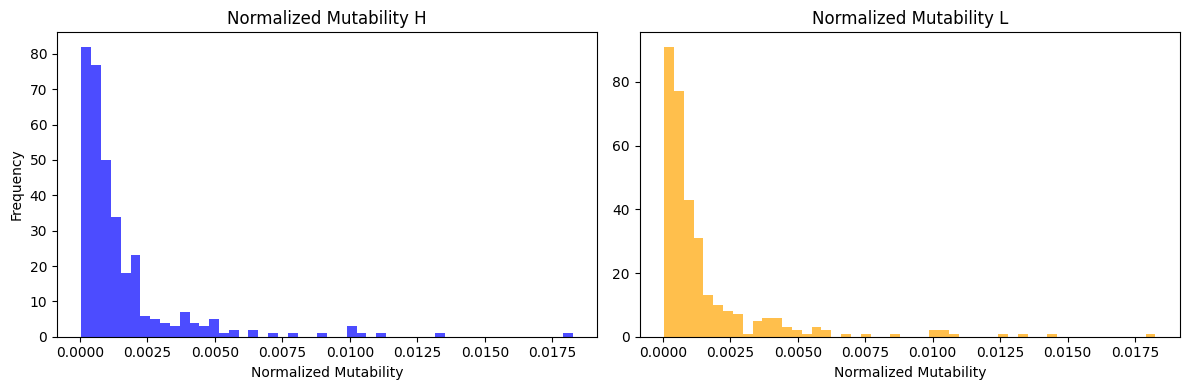

In [11]:
# make a loy-y histogram of the first row of normalized mutability scores
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(seq_data_df['norm_mutability_H'].iloc[0], bins=50, color="blue", alpha=0.7)
plt.title("Normalized Mutability H")
plt.xlabel("Normalized Mutability")
plt.ylabel("Frequency")
plt.subplot(122)
plt.hist(seq_data_df['norm_mutability_L'].iloc[0], bins=50, color="orange", alpha=0.7)
plt.title("Normalized Mutability L")
plt.xlabel("Normalized Mutability")
plt.tight_layout()

assert np.isclose(seq_data_df['norm_mutability_H'].iloc[0].sum() + seq_data_df['norm_mutability_L'].iloc[0].sum(), 1.0), "Normalized mutability scores do not sum to 1"


In [16]:
print(seq_data_df.head(2))

                                            nt_seq_H  \
0  GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...   
1  GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...   

                                            nt_seq_L  time (days)  \
0  GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...           14   
1  GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...            8   

                                   norm_mutability_H  \
0  [0.0009496252194450548, 0.0008670656061924629,...   
1  [0.0009645603854290198, 0.0008807023214800363,...   

                                   norm_mutability_L  
0  [0.0006283979819088282, 0.0005494639867798885,...  
1  [0.0006382810683850715, 0.0005581056442219313,...  


In [18]:
fivemer_sub_df.head().to_clipboard()

First let's talk about how to get to this final data structure we will want to plot.

Here is `seq_data_df` first two rows

```
                                            nt_seq_H  \
0  GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...   
1  GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...   

                                            nt_seq_L  time (days)  \
0  GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...           14   
1  GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...            8   

                                   norm_mutability_H  \
0  [0.0009496252194450548, 0.0008670656061924629,...   
1  [0.0009645603854290198, 0.0008807023214800363,...   

                                   norm_mutability_L  
0  [0.0006283979819088282, 0.0005494639867798885,...  
1  [0.0006382810683850715, 0.0005581056442219313,...  
```

These mutability vectors represent the probability of mutation at each site (if they were concatted together they would be a normalized probability vector, one per row of the data frame).

We also have a data frame `fivemer_sub_df`

```
	Fivemer	A	C	G	T
0	AAAAA	0.0	0.168399168399168	0.727650727650728	0.103950103950104
1	AAAAC	0.0	0.191268191268191	0.704781704781705	0.103950103950104
2	AAAAG	0.0	0.166320166320166	0.723492723492724	0.11018711018711
3	AAAAT	0.0	0.0909090909090909	0.863636363636364	0.0454545454545455
4	AAAAN	0.0	0.154224154224154	0.75489037989038	0.0908854658854659
```

This data frame represents the conditional probability of each possible new base in the center of the fivemer. So to calculate the probability of each possible nucleotide mutation at site i for chain X we take the entry in the norm_mutability_X column (where X is H or L), and then we multiply it by the entry in the sub_df.

For example, for the first site of the H chain, let's calculate the probability of the first G getting to be a C. We would get a NNGAG fivemer, look up the row and the C column entry, then multiply that by 0.0009496252194450548 . 

We would like to aggregate all of this into information about what is happening on the amino acid level. 

We will denote amino acid substitutions like E1(H)A which is 1-indexed site 1 mutating from E to A on the heavy chain (H). 

The aggregation desired for each mutation is an estimation of the probability of this form. For example, the first example codon change would be from GAG to CAG, which is E to Q, so we would record it as part of the probability estimation for E1(H)Q. Because of the degeneracy of the codon table, many of these NT mutations will map to the same amino acid mutation and we would like to sum probabilities on the AA mutation level, e.g. using a dict.

After aggregating these AA mutation probabilities I would like to populate a data frame. This data frame will have columns seq_idx (which is the idx of the row in `seq_data_df`) the `aa_mut` amino acid mutation, and `prob` which is the prob totaled over the nt mutations as previously described. Call this df `aa_mut_prob_df`.

No full code yet please, but let's discuss strategy and what variables / subroutines you will want to use.

Note that this is all pasted code into a notebook so feel free to define additional data structures and use them in functions.

In [21]:
# drop the position_IMGT, annotation, single_nt columns
# final_variant_scores_df = final_variant_scores_df.drop(columns=["position_IMGT", "annotation", "single_nt"])
final_variant_scores_df.head()

,target,wildtype,position,chain,mutant,mutation,codon,bind_CGG,delta_bind_CGG,n_bc_bind_CGG,n_libs_bind_CGG,expr,delta_expr,n_bc_expr,n_libs_expr
0,CGG_naive,E,1,H,A,E1(H)A,GAG,8.74239,0.11933,20,2,10.45318,-0.00246,20,2
1,CGG_naive,E,1,H,C,E1(H)C,GAG,8.60813,-0.01492,22,2,10.33348,-0.12216,22,2
2,CGG_naive,E,1,H,D,E1(H)D,GAG,8.63554,0.01249,18,2,10.50438,0.04874,18,2
3,CGG_naive,E,1,H,E,E1(H)E,GAG,8.62305,0.00000,23285,2,10.45565,0.00000,23285,2
4,CGG_naive,E,1,H,F,E1(H)F,GAG,8.75738,0.13433,29,2,10.34185,-0.11379,29,2


In [22]:
import pandas as pd
import numpy as np
from Bio.Seq import Seq
from Bio.Data import CodonTable

def calculate_aa_mutation_probabilities(seq_data_df, fivemer_sub_df):
    # Precompute codon table using Biopython
    standard_table = CodonTable.standard_dna_table
    codon_table = {}
    for codon, aa in standard_table.forward_table.items():
        codon_table[codon] = aa
    # Add stop codons
    for codon in standard_table.stop_codons:
        codon_table[codon] = '*'
    
    # Precompute fivemer substitution lookup
    fivemer_lookup = {}
    for _, row in fivemer_sub_df.iterrows():
        fivemer = row['Fivemer']
        fivemer_lookup[fivemer] = {
            'A': row['A'],
            'C': row['C'],
            'G': row['G'],
            'T': row['T']
        }
    
    aa_mutation_probs = {}
    
    # Process each sequence
    for idx, row in seq_data_df.iterrows():
        # Pad sequences for 5mer context only
        padded_seq_H = "NN" + row['nt_seq_H'] + "NN"
        padded_seq_L = "NN" + row['nt_seq_L'] + "NN"
        
        # Original mutability vectors (no padding needed)
        mut_H = row['norm_mutability_H']
        mut_L = row['norm_mutability_L']
        
        # Process heavy chain
        process_chain(padded_seq_H, mut_H, 'H', fivemer_lookup, codon_table, aa_mutation_probs)
        
        # Process light chain
        process_chain(padded_seq_L, mut_L, 'L', fivemer_lookup, codon_table, aa_mutation_probs)
    
    # Convert to dataframe
    aa_mut_prob_df = pd.DataFrame({
        'aa_mut': list(aa_mutation_probs.keys()),
        'prob_tot': list(aa_mutation_probs.values())
    })
    
    return aa_mut_prob_df

def process_chain(padded_seq, mutability, chain, fivemer_lookup, codon_table, aa_mutation_probs):
    # Original sequence without padding
    orig_seq = padded_seq[2:-2]
    
    # Process each position in the original sequence
    for pos in range(len(orig_seq)):
        # Get the original nucleotide
        orig_nt = orig_seq[pos]
        
        # Get the padded position (for fivemer context)
        padded_pos = pos + 2
        
        # Get the fivemer centered at this position
        fivemer = padded_seq[padded_pos-2:padded_pos+3]
        
        # Get the codon that this nucleotide is part of
        codon_pos = pos - (pos % 3)
        orig_codon = orig_seq[codon_pos:codon_pos + 3]
        
        # Get the original amino acid
        orig_aa = codon_table[orig_codon]
        
        # Calculate 1-indexed amino acid position
        aa_pos = (codon_pos // 3) + 1
        
        # Get the mutability at this position
        mut_prob = mutability[pos]
        
        # For each possible substitution
        for new_nt in 'ACGT':
            # Skip self-substitutions on the nucleotide level
            if new_nt == orig_nt:
                continue
            
            # Calculate the probability of this substitution
            sub_prob = fivemer_lookup[fivemer][new_nt]
            nt_mut_prob = mut_prob * sub_prob
            
            # Create the new codon
            codon_idx_in_triplet = pos % 3
            new_codon = list(orig_codon)
            new_codon[codon_idx_in_triplet] = new_nt
            new_codon = ''.join(new_codon)
            
            # Get the new amino acid
            new_aa = codon_table[new_codon]
            
            # Record all mutations, including self-mutations at AA level
            aa_mut = f"{orig_aa}{aa_pos}({chain}){new_aa}"
            
            # Update the probability for this amino acid mutation
            if aa_mut in aa_mutation_probs:
                aa_mutation_probs[aa_mut] += nt_mut_prob
            else:
                aa_mutation_probs[aa_mut] = nt_mut_prob

In [23]:
calculate_aa_mutation_probabilities(seq_data_df, fivemer_sub_df)

,aa_mut,prob_tot
0,E1(H)K,0.039288
1,E1(H)Q,0.003588
2,E1(H)*,0.005062
3,E1(H)A,0.010595
4,E1(H)G,0.027900
...,...,...
2158,T52(H)A,0.000639
2159,T52(H)S,0.000350
2160,T52(H)N,0.000318
2161,T52(H)I,0.002288
